In [1]:
# default_exp model.conv

In [2]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
# hide
from nbdev.showdoc import *

# M5 Base Model

In [4]:
# export
from fastseq.core import *
from fastseq.data.external import *
from fastseq.data.load import *
from fastseq.data.core import *
from fastseq.data.procs import *
from fastcore.all import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *
from fastai2.tabular.model import *
from fastai2.torch_basics import *
from fastai2.callback.all import *
from fastseq.metrics import *

In [5]:
from tqdm import tqdm

In [6]:
path = Path('../data/m5_tiny/rows')

In [7]:
list(path.glob('*.json'))[0]

Path('../data/m5_tiny/rows/FOODS_2_164_TX_3.json')

In [8]:
new_path = Path('../data/m5_tiny/rows2')
if not new_path.exists(): new_path.mkdir()
for f in tqdm(list(path.glob('*.json'))):
    f.copy(new_path / f.name)

# (path / '.ts_meta').copy(new_path / '.ts_meta')

100%|██████████| 299/299 [00:00<00:00, 3057.19it/s]


In [9]:
path = new_path

{'Train': 569894, 'Val': 17043, 'Validation': 299, 'Evaluation': 299}


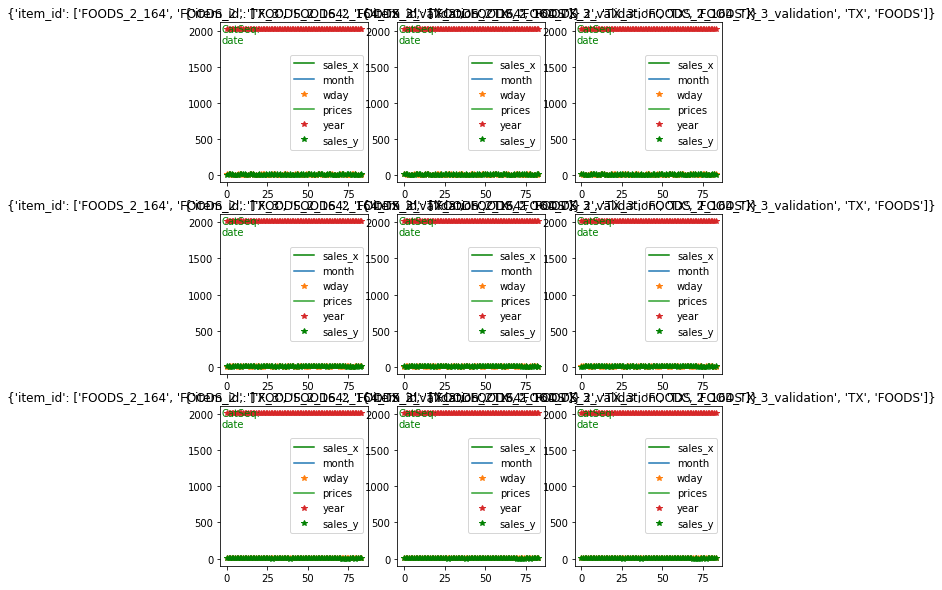

In [130]:
lookback, horizon = 28*2, 28
dl = MTSDataLoaders.from_m5_path(path, 'sales', horizon = horizon, lookback = lookback,
                                  train_start = 1600, verbose = True,
#                                   after_batch = [NormalizeSeqMulti(n_its=5,skip=[0,5])]
                                 )
dl.show_batch()

In [11]:
%%time
for o in dl.train:
    pass

CPU times: user 3.4 s, sys: 745 ms, total: 4.14 s
Wall time: 8.73 s


{"0_<class 'fastseq.core.TensorSeq'>": torch.Size([64, 1, 56]), "1_<class 'fastseq.core.TensorSeq'>": torch.Size([64, 4, 84]), "2_<class 'fastseq.data.load.CatSeqI'>": torch.Size([64, 3, 84]), "3_<class 'fastseq.data.load.TensorCatI'>": torch.Size([64, 6]), "4_<class 'fastseq.core.TensorCon'>": torch.Size([64, 0]), "5_<class 'fastseq.core.TensorSeq'>": torch.Size([64, 1, 84])}


(TensorSeq(-0.0345, device='cuda:0'),
 TensorSeq(0.9519, device='cuda:0'),
 TensorSeq(-6.2997e-08, device='cuda:0'),
 TensorSeq(0.9912, device='cuda:0'))

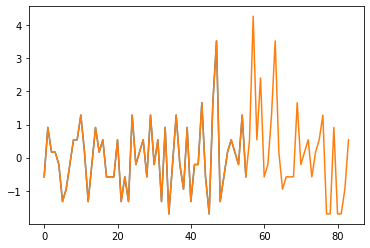

In [134]:
for o in dl.train:
    o._dict()
    break
print(o._dict())
plt.plot(o[0][0,0].cpu())
plt.plot(o[-1][0,0].cpu())
o[-1].mean(),o[-1].std(),o[0].mean(),o[0].std()

In [158]:
x = torch.randn(64,1,2*28)
x1 = torch.cat([x, x[:,0,-28:][:,None,:]],2)
x2 = torch.cat([x, x[:,0,:28][:,None,:]],2)
x = torch.cat([x1,x2],1)
x.shape

torch.Size([64, 2, 84])

In [151]:
#export
def emb_sz_rule(n_cat):
    "Rule of thumb to pick embedding size corresponding to `n_cat`"
    return min(600, round(1.6 * n_cat**0.56))

def _one_emb_sz(classes, n, sz_dict=None):
    "Pick an embedding size for `n` depending on `classes` if not given in `sz_dict`."
    sz_dict = ifnone(sz_dict, {})
    n_cat = len(classes[n])
    sz = sz_dict.get(n, int(emb_sz_rule(n_cat)))  # rule of thumb
    return n_cat,sz

def get_emb_sz(to, typ, sz_dict=None):
    return [_one_emb_sz(to.meta['classes'], col, sz_dict) for col in to.meta['col_names'][typ]]

In [161]:
# export
class SeqTabConv(Module):
    """Basic model for sequential data."""
    def __init__(self, horizon, lookback, emb_szs = None, emb_szs_ts = None, ts_con_chn = None, con_chn = None,
                 layers = [32, 32], y_range=[-5,10]):
        self.horizon, self.lookback = horizon, lookback
        if emb_szs is not None:
            self.embeds = nn.ModuleList([Embedding(ni, nf) for ni,nf in emb_szs])  
            self.n_emb = sum(e.embedding_dim for e in self.embeds)      
        else:
            self.n_emb=0
            
        if emb_szs is not None:
            self.embeds_ts = nn.ModuleList([Embedding(ni, nf) for ni,nf in emb_szs_ts])  
            self.n_emb_ts = sum(e.embedding_dim for e in self.embeds_ts)      
        else:
            self.n_emb_ts=0  
        self.conv1 = ConvLayer(315, 64, ks = 1, ndim=1)
        self.conv2 = ConvLayer(64, 1, ks = 1, ndim=1)
        self.scale = SigmoidRange(*y_range)

    def forward(self, x, ts_con, ts_cat, cat, con):   
        x1 = torch.cat([x, x[:,0,-28:][:,None,:]],2)
        x2 = torch.cat([x, x[:,0,:28][:,None,:]],2)
        x = torch.cat([x1,x2],1)
        if self.n_emb != 0:
            cat = [e(cat[:,i]) for i,e in enumerate(self.embeds)]
            cat = torch.cat(cat, 1)        
        if self.n_emb_ts != 0:
            ts_cat = [e(ts_cat[:,i]) for i,e in enumerate(self.embeds_ts)]
            ts_cat = torch.cat(ts_cat, 2).transpose(1,2)
        cat = cat[:,:,None] * torch.ones(ts_con.shape[0], self.n_emb, ts_con.shape[-1]).to(default_device())
        o = torch.ones(ts_con.shape[0], con.shape[1], ts_con.shape[-1]).to(default_device())
        con = con[:,:,None] * o
        ts = torch.cat([x, ts_con, ts_cat, cat, con.float()], 1)
        r = self.conv1(ts)        
        r = self.conv2(r)
        return r

In [162]:
lookback, horizon = 28*2, 28
emb_szs = get_emb_sz(dl.train,'cat_names', {} )
emb_szs_ts = get_emb_sz(dl.train,'ts_cat_names', {})
mdl = SeqTabConv(horizon,lookback,
             emb_szs = emb_szs,
             emb_szs_ts = emb_szs_ts,             
            ).to(default_device())
shape = list(mdl(*o[:-1]).shape)
test_eq(shape,[64,1,lookback+horizon])
print(shape)

[64, 1, 84]


In [163]:
class M5Learner(Learner): pass

@delegates(M5Learner.__init__)
def SeqTabLearner(dls, layers=None,metrics=None, emb_szs=None, emb_szs_ts=None, **kwargs):
    "Get a `Learner` using `data`, with `metrics`, including a `SeqTab` created using the remaining params."
    if layers is None: layers = [200,100]    
    emb_szs = get_emb_sz(dls.train,'cat_names', {} if emb_szs is None else emb_szs)
    emb_szs_ts = get_emb_sz(dls.train,'ts_cat_names', {} if emb_szs_ts is None else emb_szs_ts)
    
    model = SeqTabConv(dls.train.horizon, dls.train.lookback, emb_szs = emb_szs, emb_szs_ts=emb_szs_ts,  layers = layers)
    return Learner(dls, model, loss_func = F.mse_loss, opt_func= ranger, metrics=L(metrics)+L(mae, smape,mae), **kwargs)

In [164]:
set([2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2011.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2012.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0])

{2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0}

In [165]:
learn = SeqTabLearner(dl)

(0.07585775852203369, 3.6307804407442745e-07)

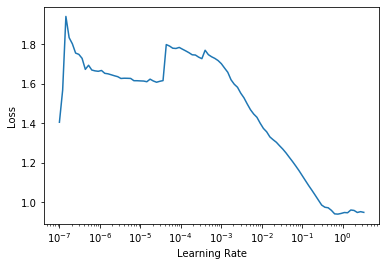

In [166]:
learn.lr_find()

In [ ]:
learn.fit(2, 1e-3)
learn.recorder.plot_loss()

epoch,train_loss,valid_loss,mae,smape,mae,time


In [ ]:
learn.lr_find()

In [ ]:
learn.fit(3, 1e-5)
learn.recorder.plot_loss()

In [ ]:
learn.show_results(show_kwargs = dict(extra = False))

_______

_______

_______

_______

_______

_______

In [108]:
inputs,preds,targs,decoded,losses = learn.get_preds(3, with_decoded = True, with_input=True, with_loss=True)
decoded[-28:]

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2735, 0.2723]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0380, 0.3336, 0.3280]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0661, 0.0397]],

        ...,

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2311, 0.2174]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0497, 0.0383]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1898, 0.1695]]])

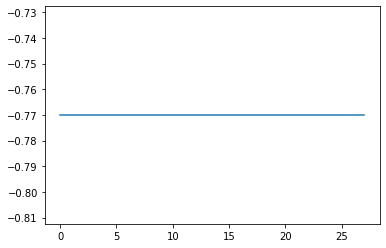

In [111]:
plt.plot(targs[0,:,-28:].T)

In [107]:

# inputs,preds,targs,decoded,losses
def make_pred(learn, dl = 2):
    inputs,preds,targs,decoded,losses = learn.get_preds(3, with_decoded = True, with_input=True, with_loss=True)
    predictions = (decoded ).round() #TODO std
    return predictions[:,0,:]
    

In [ ]:

for pred in make_pred(learn, dl = 2):
    o =','.join(L(list(pred[-28:].numpy())).map(int).map(str))
    print(o)
    break
plt.plot(pred)        

In [ ]:
plt.plot(pred[-1,].T)

In [ ]:

def make_submision_file(learn):
    dct = {}
    for i, (file, pred) in enumerate(zip(learn.dls[2].dataset, make_pred(learn, 2))):
        name = file.name.replace('.json','_validation')
        pred =','.join(L(list(pred[-28:].numpy())).map(int).map(str))
        dct[name] = pred

    for i, (file, pred) in enumerate(zip(learn.dls[3].dataset, make_pred(learn, 3))):
        name = file.name.replace('.json','_evaluation')
        pred =','.join(L(list(pred[-28:].numpy())).map(int).map(str))
        dct[name] = pred
    return dct

In [ ]:
# export
dct = make_submision_file(learn)
dct['HOBBIES_1_028_CA_1_validation']

In [ ]:
def make_file(learn, dct):
    with open(learn.path / 'submision_file.csv','w') as f_w:
        with open(Path('../data/m5/sample_submission.csv')) as f:
            f_w.write('id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28')
            for line in f:
                f.write(dct[line.split(',')[0]])
            
M5Learner.make_submision_file = make_submision_file

In [ ]:

make_file(learn, dct)

In [ ]:
!kaggle competitions submit -c m5-forecasting-accuracy -f '../data/m5/rows2/submision_file.csv' -m 'initial sub 0.0.1'

In [ ]:
# hide
from nbdev.export import *
notebook2script()

In [83]:
git_add('11_model.conv.ipynb', commit_msg='working loop')

Converted 11_model.conv.ipynb.


['/home/tako/dev/fastseq/fastseq/model/conv.py',
 '/home/tako/dev/fastseq/nbs/11_model.conv.ipynb']